In [1]:
import urllib
import json
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image, display

%matplotlib inline

## Get data

In [2]:
resp = urllib.request.urlopen('http://data.rcc-acis.org/StnMeta?county=41039').read()
stationJson = json.loads(resp)['meta']

elev_data = {col: [s[col] for s in stationJson if 'elev' in list(s.keys())] for col in ['uid', 'elev']}
elev_df = pd.DataFrame(elev_data, columns=['uid', 'elev'])

np.savetxt('elev_data.txt', elev_df, fmt=['%i', '%.1f'])

## Elevation histogram

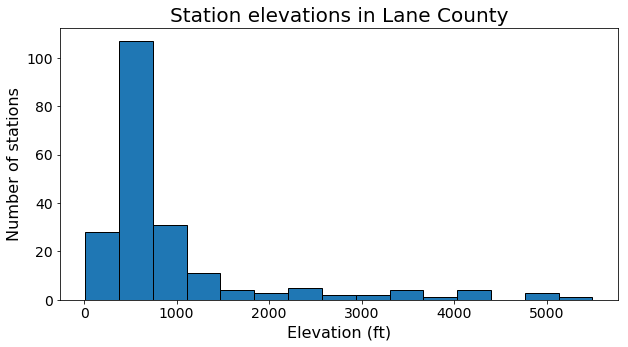

In [3]:
plt.figure(figsize=(10,5))
plt.hist(elev_df['elev'], bins=15, edgecolor='k')
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Station elevations in Lane County', size=20)
plt.xlabel('Elevation (ft)', size=16)
plt.ylabel('Number of stations', size=16)

plt.show()

## Stations in Eugene/Florence b/w 1000-2500 ft elevation

In [4]:
eug_flor_st = [s for s in stationJson if re.match('(?i)Eugene', s['name']) or re.match('(?i)Florence', s['name'])]
eug_flor_st_ID = [s['uid'] for s in eug_flor_st]
elev_df_eug_flor = elev_df[(elev_df['elev'] <= 2500) & (elev_df['elev'] >= 1000) & elev_df['uid'].map(lambda x: x in eug_flor_st_ID)]

np.savetxt('elev_data_eug_flor.txt', elev_df_eug_flor, fmt=['%i', '%.1f'])

## Eugene Airport, 2009

In [5]:
resp = urllib.request.urlopen('http://data.rcc-acis.org/StnData?uid=15218&sdate=2009-01-01&edate=2010-01-10&elems=1,2,4,10,11').read()
ap_json = json.loads(resp)['meta']
ap_data = json.loads(resp)['data']
ap_df = pd.DataFrame(ap_data, columns=['date', 'maxt', 'mint', 'prec', 'snow', 'snwd'])
ap_df['prec'] = pd.to_numeric(ap_df['prec'], errors='coerce')

In [6]:
ap_ht = ap_df['date'][ap_df['maxt'].idxmax()]
ap_lt = ap_df['date'][ap_df['mint'].idxmin()]
ap_gp = ap_df['date'][ap_df['prec'].idxmax()]

print('Date of highest temperature:', ap_ht)
print('Date of lowest temperature:', ap_lt)
print('Date of greatest percipication:', ap_gp)

Date of highest temperature: 2009-08-18
Date of lowest temperature: 2009-12-08
Date of greatest percipication: 2009-06-13


In [7]:
ap_df_dry = ap_df[ap_df['prec'] == 0]['date']

droughts = []
first = last = datetime.strptime(ap_df_dry.iloc[0], '%Y-%m-%d')
for x in ap_df_dry.iloc[1:]:
    day = datetime.strptime(x, '%Y-%m-%d')
    if (day - timedelta(days=1) == last):
        last = day
    else:
        droughts.append((first.strftime('%Y-%m-%d'), (last - first).days))
        first = last = day
droughts.append((first.strftime('%Y-%m-%d'), (last - first).days))

droughts_df = pd.DataFrame(droughts, columns=['date', 'length'])
max_date, max_len = droughts_df.iloc[droughts_df['length'].idxmax()]
print('Longest drought: {} days starting on {}'.format(max_len, max_date))

Longest drought: 17 days starting on 2009-07-18


In [8]:
ap_df_wet = ap_df[ap_df['prec'] > 0].loc[:,['date', 'prec']]

wet_dates = []
wet_sum = []
for i in range(len(ap_df_wet[:-14])):
    x = ap_df_wet[i:i+15]
    wet_dates.append(x['date'].iloc[0])
    wet_sum.append(sum(x['prec']))
ap_df_wettest = pd.DataFrame({'date': wet_dates, 'prec': wet_sum})
max_prec_date, max_prec = [ap_df_wettest.iloc[ap_df_wettest['prec'].idxmax()][i] for i in ['date', 'prec']]
print('Wettest 15-day period: {} inches start on {}'.format(max_prec, max_date))

Wettest 15-day period: 5.98 inches start on 2009-07-18


In [9]:
ap_hot = ap_df[ap_df['maxt'].astype(float) > 90.].loc[:,['date', 'maxt']]
hot_days = len(ap_hot)

ap_cold = ap_df[ap_df['mint'].astype(float) < 32.].loc[:,['date', 'maxt']]
cold_days = len(ap_cold)

print('Days above 90 degrees:', hot_days)
print('Days below 32 degrees:', cold_days)

Days above 90 degrees: 18
Days below 32 degrees: 66


## Eugene Airport, 1950-2017

In [10]:
resp = urllib.request.urlopen('http://data.rcc-acis.org/StnData?uid=15218&sdate=1950-01-01&edate=2017-01-01&elems=1,2,4,10,11').read()
ap_json = json.loads(resp)['meta']
ap_data = json.loads(resp)['data']
ap_df = pd.DataFrame(ap_data, columns=['date', 'maxt', 'mint', 'prec', 'snow', 'snwd'])

# Turn T's and M's into nan's
ap_df['maxt'] = pd.to_numeric(ap_df['maxt'], errors='coerce')
ap_df['prec'] = pd.to_numeric(ap_df['prec'], errors='coerce')

# Get years, months, and days into separate columns
ap_df['year'] = ap_df['date'].str[:4].astype(int)
ap_df['month'] = ap_df['date'].str[5:7].astype(int)
ap_df['day'] = ap_df['date'].str[-2:].astype(int)

## Days above 90F, b/w Jul 15 - Aug 25

In [11]:
ap_hot = ap_df[ap_df['maxt'] > 90]
ap_hot_summer = ap_hot[((ap_hot['month'] == 7) & (ap_hot['day'] >= 15)) | ((ap_hot['month'] == 8) & (ap_hot['day'] <= 25))]

rng = np.arange(1950, 2018, 5)
n_hot = [len(ap_hot_summer[(ap_hot_summer['year'] >= period) & (ap_hot_summer['year'] <= period+4)]) for period in rng]

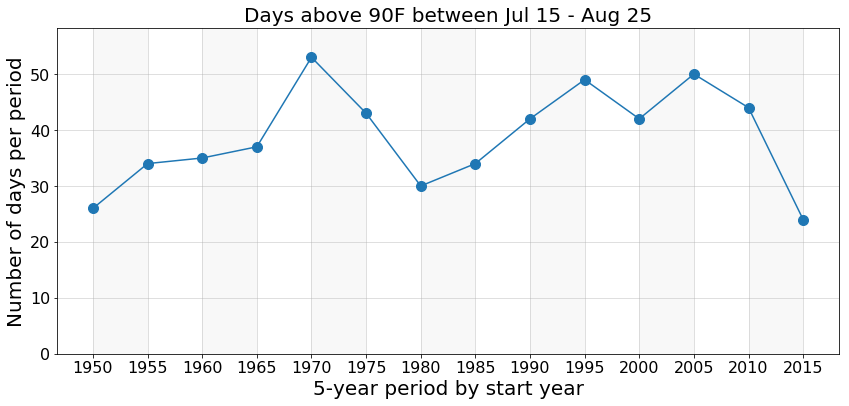

In [12]:
plt.figure(figsize=(14,6))
plt.plot(rng, n_hot, '.-', markersize=20)
# plt.step(rng, n_hot, where='post')
plt.ylim(0, max(n_hot)*1.1)
plt.xticks(rng, size=16)
plt.yticks(size=16)
plt.title('Days above 90F between Jul 15 - Aug 25', size=20)
plt.xlabel('5-year period by start year', size=20)
plt.ylabel('Number of days per period', size=20)
for i in rng[::2]:
    plt.axvspan(i, i+5, facecolor="grey", alpha=0.05)
ax = plt.axes()
ax.grid(alpha=0.5)

plt.show()

## Three longest drought durations

In [13]:
ap_hot_dry = ap_hot_summer[ap_hot_summer['prec'] == 0]['date']

droughts = []
first = last = datetime.strptime(ap_hot_dry.iloc[0], '%Y-%m-%d')
for x in ap_hot_dry.iloc[1:]:
    day = datetime.strptime(x, '%Y-%m-%d')
    if (day - timedelta(days=1) == last):
        last = day
    else:
        droughts.append((first.strftime('%Y-%m-%d'), (last - first).days))
        first = last = day
droughts.append((first.strftime('%Y-%m-%d'), (last - first).days))

droughts_df = pd.DataFrame(droughts, columns=['date', 'length'])
droughts_df_sort = droughts_df.sort_values('length', ascending=False)

max_date, max_len = droughts_df_sort.iloc[0]
max_date_2, max_len_2 = droughts_df_sort.iloc[1]
max_date_3, max_len_3 = droughts_df_sort.iloc[2]

print('Longest drought: {} days starting on {}'.format(max_len, max_date))
print('2nd Longest drought: {} days starting on {}'.format(max_len_2, max_date_2))
print('3rd Longest drought: {} days starting on {}'.format(max_len_3, max_date_3))

Longest drought: 7 days starting on 1967-08-12
2nd Longest drought: 7 days starting on 1962-07-21
3rd Longest drought: 6 days starting on 2004-08-08


## Total precipitation in winter seasons

In [14]:
rainy_df = ap_df[ap_df['month'].isin([1,2,11,12]) & ap_df['prec'] > 0]

rng = np.arange(1950, 2018, 5)
prec = [sum(rainy_df[(rainy_df['year'] >= period) & (rainy_df['year'] <= period+4)]['prec']) for period in rng]

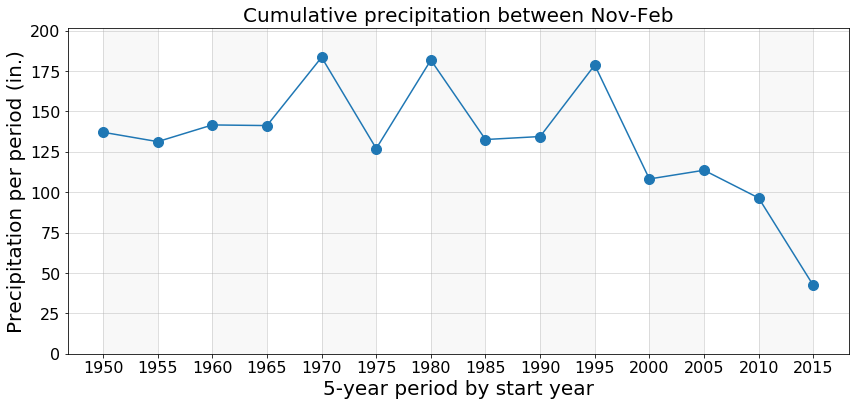

In [15]:
plt.figure(figsize=(14,6))
plt.plot(rng, prec, '.-', markersize=20)
# plt.step(rng, n_hot, where='post')
plt.ylim(0, max(prec)*1.1)
plt.xticks(rng, size=16)
plt.yticks(size=16)
plt.title('Cumulative precipitation between Nov-Feb', size=20)
plt.xlabel('5-year period by start year', size=20)
plt.ylabel('Precipitation per period (in.)', size=20)
for i in rng[::2]:
    plt.axvspan(i, i+5, facecolor="grey", alpha=0.05)
ax = plt.axes()
ax.grid(alpha=0.5)

plt.show()

### Comments:
Total precipitation in this season seems to be dropping over the last few years! At least based on 2000-2010. The last point is only low because it is sampling from 2015-16.

## Highest, lowest cumulative rainfall days

In [16]:
dates = np.sort(list(set(rainy_df['date'].str[-5:])))
rain_per_date = pd.DataFrame([(x, sum(rainy_df[rainy_df['date'].str[-5:] == x]['prec'])) for x in dates],
                             columns=['date', 'prec'])

max_prec_day, max_prec = rain_per_date.max()
min_prec_day, min_prec = rain_per_date.min()

print('Highest cumulative rainfall: {:.2f} inches on {}'.format(max_prec, max_prec_day))
print('Lowest cumulative rainfall: {:.2f} inches on {}'.format(min_prec, min_prec_day))

Highest cumulative rainfall: 25.65 inches on 12-31
Lowest cumulative rainfall: 2.33 inches on 01-01


## Snowfall in Redmond, OR

In [17]:
resp = urllib.request.urlopen('http://data.rcc-acis.org/StnData?uid=15234&sdate=1950-01-01&edate=2017-01-01&elems=10').read()
rd_json = json.loads(resp)['meta']
rd_data = json.loads(resp)['data']
rd_df = pd.DataFrame(rd_data, columns=['date', 'snow'])

# Turn T's and M's into nan's
rd_df['snow'] = pd.to_numeric(rd_df['snow'], errors='coerce')

# Get years, months, and days into separate columns
rd_df['year'] = rd_df['date'].str[:4].astype(int)
rd_df['month'] = rd_df['date'].str[5:7].astype(int)
rd_df['day'] = rd_df['date'].str[-2:].astype(int)

In [18]:
snowy_df = rd_df[rd_df['snow'] > 0]

years = np.arange(1950, 2018)

snow1 = [
    sum(snowy_df[
        (snowy_df['year'] == year) & 
        ((snowy_df['month'].isin([11,12,1])) | 
         ((snowy_df['month'] == 2) & (snowy_df['day'] <= 15))
        )
    ]['snow']) for year in years]

snow2 = [
    sum(snowy_df[
        (snowy_df['year'] == year) & 
        ((snowy_df['month'] == 4) | 
         ((snowy_df['month'] == 5) & (snowy_df['day'] <= 15))
        )
    ]['snow']) for year in years]

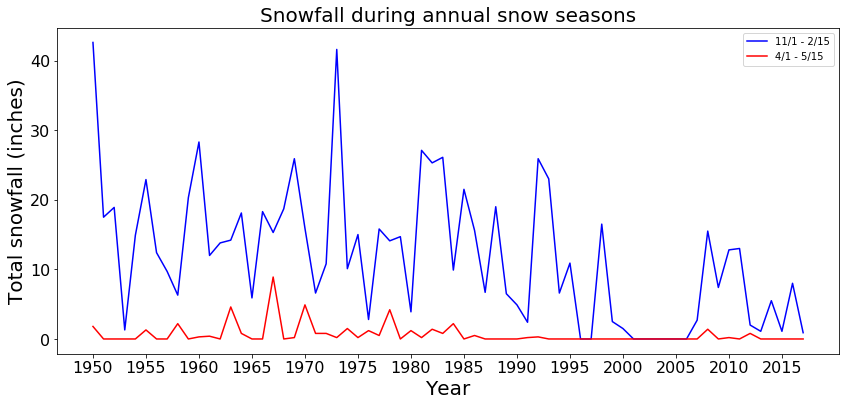

In [19]:
plt.figure(figsize=(14,6))
plt.plot(years, snow1, 'b', label='11/1 - 2/15', markersize=12)
plt.plot(years, snow2, 'r', label='4/1 - 5/15', markersize=12)
plt.xticks(np.arange(1950, 2020, 5), size=16)
plt.yticks(size=16)
plt.title('Snowfall during annual snow seasons', size=20)
plt.xlabel('Year', size=20)
plt.ylabel('Total snowfall (inches)', size=20)

plt.legend(loc='upper right')
plt.show()

### Comment:
Not surprisingly, the spring months don't have as much snowfall as the winter months. Both seasons show a steady decline in snowfall. There was a very snow-less period from 2000-2005.

## Panoply

The numpy command ``arange`` takes in endpoints and creates an array ranging from the first argument to one minus the last argument (given the default step size of 1), so ``arange(nx*ny)`` makes an array of values ``1, 2, 3, ... , 1198, 1199``. This is then reshaped by the ``shape`` command in the next line so that the array becomes a 600-by-1200 array.

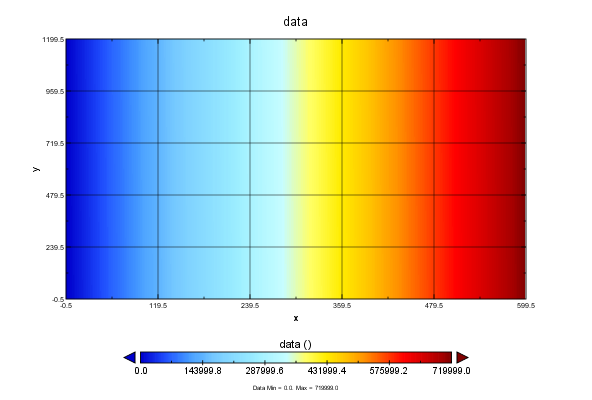

In [20]:
display(Image(filename='simple_xy_plot.png'))

### Note: 
I wasn't able to get netCDF4 working on my computer, and didn't have time to get this working on ACISS. So here I present the data via a `pcolor` plot on `matplotlib`.

In [21]:
# pull data
resp = urllib.request.urlopen('http://data.rcc-acis.org/MultiStnData?state=OR,WA&date=2008-07-04&elems=maxt,mint').read()
stationJson = json.loads(resp)['data']

# build dataframe for data
lat = []
long = []
maxt = []
for j in range(len(stationJson)):
    if list(stationJson[j]['meta'].keys())[1]=='ll':
        long.append(stationJson[j]['meta']['ll'][0])
        lat.append(stationJson[j]['meta']['ll'][1])
        maxt.append(stationJson[j]['data'][0])
df = pd.DataFrame(list(zip(*[lat, long, maxt])), columns=['lat', 'long', 'maxt'])

# Clean up data: get rid of non-number temperatures, round lat's and long's
df['maxt'] = pd.to_numeric(df['maxt'], errors='coerce')
df = df[df['maxt'] > 0]
df['lat'] = df['lat'].round(1)
df['long'] = df['long'].round(1)

In [22]:
# Create arrays for 'heat map'
lat_arr = np.arange(min(np.floor(lat)),max(np.floor(lat)),0.1)
long_arr = np.arange(min(np.floor(long)),max(np.floor(long)),0.1)
t_arr = np.zeros((len(long_arr), len(lat_arr)))
t_arr_n = np.zeros((len(long_arr), len(lat_arr)))
t_arr_avg = np.zeros((len(long_arr), len(lat_arr)))

for i in range(len(df)):
    x_index = np.where(np.isclose(df['long'].iloc[i], long_arr))[0]
    y_index = np.where(np.isclose(df['lat'].iloc[i], lat_arr))[0]
    if (len(x_index) > 0) & (len(y_index) > 0):
        t_arr[x_index[0], y_index[0]] += df['maxt'].iloc[i]
        t_arr_n [x_index[0], y_index[0]] += 1.

for i in range(len(long_arr)):
    for j in range(len(lat_arr)):
        if t_arr[i,j] > 0:
            t_arr_avg[i,j] = t_arr[i,j] / t_arr_n[i,j]

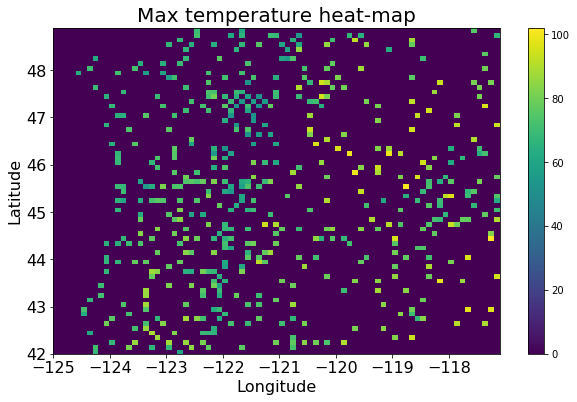

In [23]:
plt.figure(figsize=(10,6))
plt.pcolor(long_arr, lat_arr, np.transpose(t_arr_avg))
plt.xticks(size=16)
plt.yticks(size=16)
plt.title('Max temperature heat-map', size=20)
plt.xlabel('Longitude', size=16)
plt.ylabel('Latitude', size=16)
plt.colorbar()
plt.show()

There seems to some vague pattern here. The temeratures seem to come in bands, i.e. it's colder towards the west.